В данном ноутбуке я создам базовый класс, на основе которого обучу сверточную графовую нейронную сеть.

Импортируем необходимые библиотеки

In [2]:
import os
import json
import numpy as np
import torch
import nni
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import CIFAR10
from nni.nas.evaluator.pytorch import DataLoader, Classification
from nni.nas.hub.pytorch import DARTS as DartsSpace
from nni.nas.space import model_context
from tqdm import tqdm
from IPython.display import clear_output

from sklearn.preprocessing import OneHotEncoder
import re
import io
from graphviz import Digraph
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

import scipy.stats as sps
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from IPython.display import clear_output

/home/alexander/.local/lib/python3.12/site-packages/nni/nas/nn/pytorch/layers.py:94: RuntimeWarning: <class 'torch.nn.parameter.Buffer'> is found to be not a nn.Module, which is unexpected. It means your PyTorch version might not be supported.
  warnings.warn(f'{obj} is found to be not a nn.Module, which is unexpected. '


Основные операция DARTS search space. Добавил 'none' для начальных вершин.

In [3]:

DARTS_OPS = [
        'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

encoder = OneHotEncoder(handle_unknown='ignore')


Для графовой нейронной сети нам необходимо привести операции к числовому виду. Воспользуемся one-hot-encoder.

In [4]:
encoder = OneHotEncoder(handle_unknown='ignore')
ops_array = np.array(DARTS_OPS).reshape(-1, 1)

DARTS_OPS_ONE_HOT = encoder.fit_transform(ops_array).toarray()

print(DARTS_OPS_ONE_HOT)

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


Загрузим архитектуры обученных моделей, их предсказания и точность.

In [5]:
def load_json_from_directory(directory_path):
    """
    Обходит директорию и создает список словарей из JSON файлов.

    Аргументы:
        directory_path (str): Путь к директории, содержащей JSON файлы.

    Возвращает:
        list: Список словарей, загруженных из JSON файлов.
    """
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [6]:
models_dict = load_json_from_directory('second_dataset/')

Посмотрю как распределена точность моделей

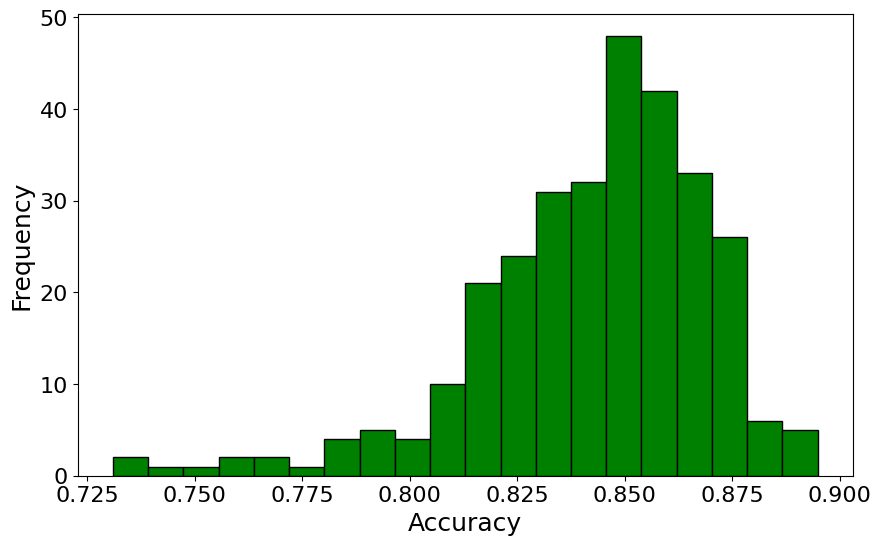

In [7]:
accuracies = [model['test_accuracy'] for model in models_dict]

plt.figure(figsize=(10, 6))

plt.hist(accuracies, bins=20, edgecolor='black', color="green")
# plt.title('Distribution of Model Accuracies')
plt.xlabel('Accuracy', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [8]:
def extract_cells(arch_dict):
    normal_cell, reduction_cell = [], []
    tmp_list = []

    for key, value in arch_dict["architecture"].items():
        if key.startswith("normal/") or key.startswith("reduce/"):
            tmp_list.extend([key, value])

        if len(tmp_list) == 4:
            tmp_list.pop(2)
            if key.startswith("normal/"):
                normal_cell.append(tmp_list)
            else:
                reduction_cell.append(tmp_list)
            tmp_list = []

    return normal_cell, reduction_cell

Создадам базовый класс узла графа

In [9]:
class Vertex:
    def __init__(self, op, in_channel, out_channel):
        self.op = op
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.op_one_hot = DARTS_OPS_ONE_HOT[DARTS_OPS.index(op)]

    def __str__(self):
        return f"Op: {self.op} | In: {self.in_channel} | Out: {self.out_channel}"
    def __repr__(self):
        return self.__str__()

Напишу сам класс графа. 

Замечу, что в классе будет хранится индекс соответствующий положению архитектуры в массиве словарей импортированном раннее.

In [10]:
class Graph(torch.utils.data.Dataset):
    def __init__(self, model_dict, index=0):
        self.model_dict = model_dict
        self.normal_cell, self.reduction_cell = extract_cells(model_dict)

        self._normal_graph = self.make_graph(self.normal_cell)
        self._reduction_graph = self.make_graph(self.reduction_cell)

        self.normal_num_vertices, self.reduction_num_vertices = self.__len__()

        self.graph = self.make_full_graph()
        self.index = index

    def __len__(self):
        max_normal_out = max(vertex.out_channel for vertex in self._normal_graph)
        max_reduction_out = max(vertex.out_channel for vertex in self._reduction_graph)
        return max_normal_out, max_reduction_out

    def graph_size(self, graph):
        return max((vertex.out_channel for vertex in graph), default=0)

    def make_full_graph(self):
        graph = [vertex for vertex in self._normal_graph]
        graph = self._unite_graphs(graph, self._reduction_graph)

        max_channel_diff, _ = self.__len__()
        graph.append(Vertex("none", max_channel_diff * 2 + 1, max_channel_diff * 2 + 1))

        return graph

    def _unite_graphs(self, graph1, graph2):
        graph1_size = self.graph_size(graph1)
        new_graph = [vertex for vertex in graph1]
        for vertex in graph2:
            new_vertex = Vertex(
                vertex.op,
                vertex.in_channel + graph1_size,
                vertex.out_channel + graph1_size,
            )
            new_graph.append(new_vertex)

        new_graph.sort(key=lambda vertex: (vertex.in_channel, vertex.out_channel))

        return new_graph

    def make_graph(self, cell):
        graph = []
        for value in cell:
            in_channel = int(value[2][0])
            out_channel = int(re.search(r"op_(\d+)_", value[0]).group(1))
            op = value[1]
            graph.append(Vertex(op, in_channel, out_channel))
        graph.append(Vertex("none", 0, 0))
        graph.append(Vertex("none", 1, 1))

        graph.sort(key=lambda vertex: (vertex.in_channel, vertex.out_channel))

        return graph

    def show_graph(self):
        adj_matrix, operations, _ = self.get_adjacency_matrix()
        graph_name = "Graph"

        dot = Digraph(comment=graph_name, format="png")
        dot.attr(rankdir="TB")

        num_nodes = len(self.graph)

        # Добавляем узлы с оригинальными метками
        for idx, vertex in enumerate(self.graph):
            label = (
                f"{{Op: {vertex.op} | "
                f"In: {vertex.in_channel} | "
                f"Out: {vertex.out_channel}}}"
            )
            dot.node(str(idx), label=label, shape="record")

        # Добавляем связи на основе матрицы смежности
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_matrix[i, j] == 1:
                    dot.edge(str(i), str(j))

        display(dot)

    def get_normal_graph(self):
        return self._normal_graph

    def get_reduction_graph(self):
        return self._reduction_graph

    def get_adjacency_matrix(self):
        adj_matrix_size = len(self.graph)
        max_channel_diff, _ = self.__len__()
        adj_matrix = np.zeros(shape=(adj_matrix_size, adj_matrix_size))

        operations = [vertex.op for vertex in self.graph]
        operations_one_hot = [vertex.op_one_hot for vertex in self.graph]
        for i in range(adj_matrix_size):
            for j in range(adj_matrix_size):
                if j == i:
                    continue
                vertex_1 = self.graph[i]
                vertex_2 = self.graph[j]

                if (vertex_1.out_channel == vertex_2.in_channel) and (
                    (
                        vertex_1.in_channel <= max_channel_diff
                        and vertex_2.out_channel <= max_channel_diff
                    )
                    or (
                        vertex_1.in_channel >= max_channel_diff
                        and vertex_2.out_channel >= max_channel_diff
                    )
                ):

                    adj_matrix[i, j] = 1

                if (  # Добавляем ребро из c_k на вход следующей клетке
                    (vertex_1.op == "none")
                    and (vertex_2.op == "none")
                    and (vertex_1.out_channel == 1)
                    and (vertex_2.in_channel == 6)
                ):
                    adj_matrix[i, j] = 1

        # Соединим оставшиеся узлы с выходом.

        for i in range(adj_matrix_size):
            for j in range(adj_matrix_size):
                if j == i:
                    continue
                vertex_1 = self.graph[i]
                vertex_2 = self.graph[j]

                if (np.all(adj_matrix[i, :] == 0)) and (
                    (
                        (vertex_2.op == "none")
                        and (vertex_2.in_channel == max_channel_diff)
                        and (vertex_1.in_channel < max_channel_diff)
                    )
                    or (
                        (vertex_2.out_channel == 2 * max_channel_diff + 1)
                        and (vertex_1.out_channel > max_channel_diff)
                    )
                ):
                    adj_matrix[i, j] = 1

        adj_matrix = np.array(adj_matrix)
        operations_one_hot = np.array(operations_one_hot)
        return adj_matrix, operations, operations_one_hot

In [11]:
graph = Graph(models_dict[0])

Посмотрю как выглядит граф.

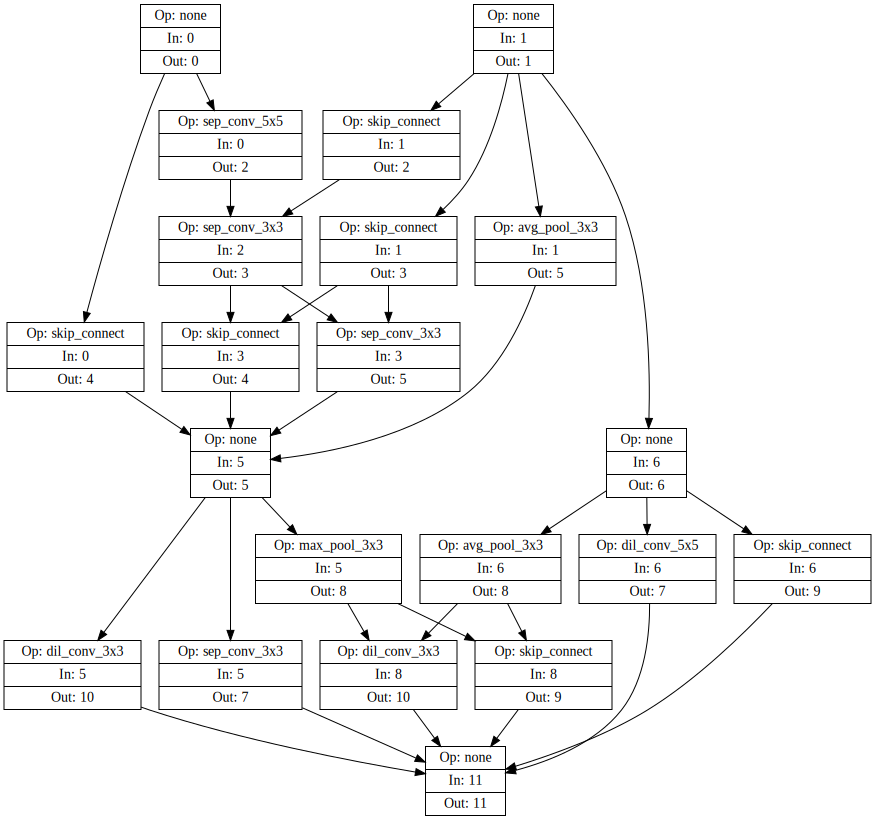

In [12]:
graph.show_graph()

In [13]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


In [14]:
graph._normal_graph

[Op: none | In: 0 | Out: 0,
 Op: sep_conv_5x5 | In: 0 | Out: 2,
 Op: skip_connect | In: 0 | Out: 4,
 Op: none | In: 1 | Out: 1,
 Op: skip_connect | In: 1 | Out: 2,
 Op: skip_connect | In: 1 | Out: 3,
 Op: avg_pool_3x3 | In: 1 | Out: 5,
 Op: sep_conv_3x3 | In: 2 | Out: 3,
 Op: skip_connect | In: 3 | Out: 4,
 Op: sep_conv_3x3 | In: 3 | Out: 5]

In [15]:
graph._reduction_graph


[Op: none | In: 0 | Out: 0,
 Op: sep_conv_3x3 | In: 0 | Out: 2,
 Op: max_pool_3x3 | In: 0 | Out: 3,
 Op: dil_conv_3x3 | In: 0 | Out: 5,
 Op: none | In: 1 | Out: 1,
 Op: dil_conv_5x5 | In: 1 | Out: 2,
 Op: avg_pool_3x3 | In: 1 | Out: 3,
 Op: skip_connect | In: 1 | Out: 4,
 Op: skip_connect | In: 3 | Out: 4,
 Op: dil_conv_3x3 | In: 3 | Out: 5]

Матрица смежности и описания узлов(сначала в виде строк, потом в виде one-hot векторов) представлены так

In [16]:
graph.get_adjacency_matrix()

(array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


Рассчитаю разнообразие наивно -- просто буду говорить каков процент совпадений ответов у моделей 

In [17]:
def get_diversity(model_dict_1, model_dict_2):
    model_1_answers = np.array(model_dict_1["test_predictions"])
    model_2_answers = np.array(model_dict_2["test_predictions"])

    return np.mean(model_1_answers == model_2_answers)

Построю матрицу разнообразия

In [18]:
diversity_matrix = np.zeros((len(models_dict), len(models_dict))) + np.eye(
    len(models_dict)
)

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversity_matrix[i, j] = get_diversity(models_dict[i], models_dict[j])
        diversity_matrix[j, i] = diversity_matrix[i, j]

100%|██████████| 300/300 [01:00<00:00,  4.94it/s]


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 19177.47it/s]


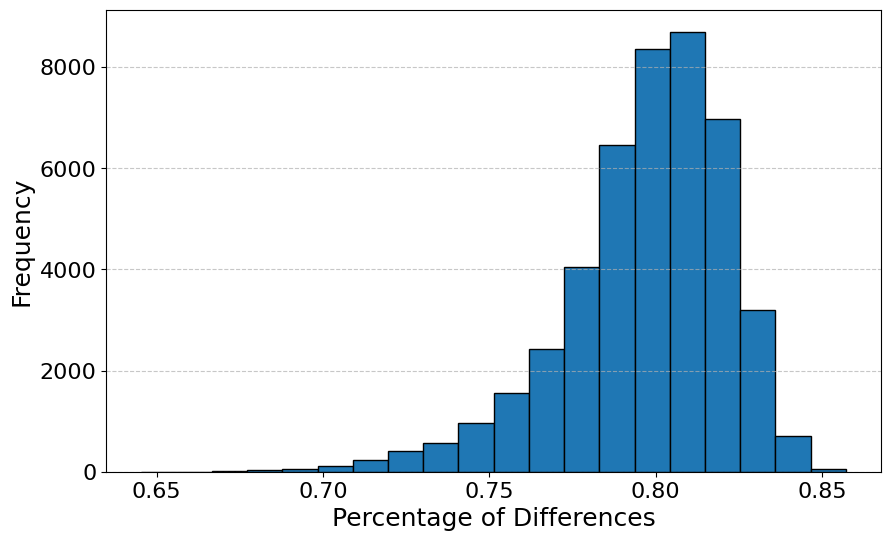

In [19]:
diversities = []

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversities.append(diversity_matrix[i, j])
diversities = np.array(diversities)

plt.figure(figsize=(10, 6))

plt.hist(diversities, bins=20, edgecolor="black")
# plt.title("Distribution of Model Diversity")
plt.xlabel("Percentage of Differences", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Для triplet loss нам нужно будет подбирать positive и negative примеры, для этого удобно будет использовать дискретную матрицу разнообразия

В ней 1 -- positive, -1 -- negative, 0 в ином случае.

In [20]:
def create_discrete_diversity_matrix(models_dict, diversity_matrix):
    discrete_diversity_matrix = np.zeros((len(models_dict), len(models_dict)))

    upper_margins = np.quantile(diversity_matrix, 0.90, axis=1)
    lower_margins = np.quantile(diversity_matrix, 0.1, axis=1)

    discrete_diversity_matrix[diversity_matrix > upper_margins[:, None]] = 1
    discrete_diversity_matrix[diversity_matrix < lower_margins[:, None]] = -1

    return discrete_diversity_matrix

In [21]:
def get_positive_and_negative(diversity_matrix, index, dataset=None):
    positive = np.where((diversity_matrix[index, :] == 1) & (np.arange(len(diversity_matrix)) != index))[0].tolist()
    negative = np.where(diversity_matrix[index, :] == -1)[0].tolist()

    if dataset is not None:
        appropriate_indexes = [dataset[i][2] for i in range(len(dataset))]

        positive = [appropriate_indexes.index(idx) for idx in positive if idx in appropriate_indexes]
        negative = [appropriate_indexes.index(idx) for idx in negative if idx in appropriate_indexes]

    if not positive or not negative:
        print("Both positive and negative samples are empty!")
        return None, None

    return np.random.choice(positive), np.random.choice(negative)


In [22]:
discrete_diversity_matrix = create_discrete_diversity_matrix(models_dict, diversity_matrix)

Код GCN

In [23]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.batch_norm = nn.BatchNorm1d(out_features)

    def forward(self, adj, x):
        support = self.linear(x)
        output = torch.spmm(adj, support)
        output = self.batch_norm(output)
        return output

class SimpleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=16, dropout=0.5):
        super(SimpleGCN, self).__init__()
        self.gc1 = GraphConvolution(input_dim, hidden_dim)
        self.gc2 = GraphConvolution(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, adj, x):
        x = F.relu(self.gc1(adj, x))
        x = self.dropout(x)
        x = F.relu(self.gc2(adj, x))
        x = self.dropout(x)

        x = torch.max(x, dim=0).values 
        x = self.fc(x)
        
        return x


In [24]:
class GCN(nn.Module):
    def __init__(self, input_dim, output_dim=16, dropout=0.5):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(input_dim, 64)
        self.gc2 = GraphConvolution(64, 128)
        self.gc3 = GraphConvolution(128, 64)
        self.fc = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(64)
        
        # Параметры для attention (Key & Query)
        self.key = nn.Linear(128, 128)
        self.query = nn.Linear(128, 128)
        
        # Проекция residual connection
        self.residual_proj = nn.Linear(input_dim, 64) if input_dim != 64 else nn.Identity()

    def forward(self, adj, x):
        residual = self.residual_proj(x)
        
        x = F.leaky_relu(self.gc1(adj, x))
        x = self.dropout(x)
        x = F.leaky_relu(self.gc2(adj, x))
        x = self.dropout(x)
        
        # Вычисление self-attention scores
        keys = self.key(x)  # [N, 128]
        queries = self.query(x)  # [N, 128]
        attn_scores = torch.mm(queries, keys.T)  # [N, N]
        
        # Применение маски adjacency matrix и softmax
        attn_scores = attn_scores * adj.to_dense()  # Маскирование несвязанных узлов
        attn_scores = F.softmax(attn_scores, dim=-1)
        
        # Взвешенная сумма значений (x)
        x = torch.mm(attn_scores, x)  # [N, N] * [N, 128] → [N, 128]
        
        x = F.leaky_relu(self.gc3(adj, x))
        x = self.layer_norm(x + residual)
        x = self.dropout(x)
        
        x = torch.max(x, dim=0).values  # Глобальный max pooling
        x = self.fc(x)
        
        return x

Кастомный датасет, перевожу основные величины в тензоры

In [25]:
class CustomDataset(Dataset):
    def __init__(self, graphs):
        self.indexes = []
        self.adjs, self.features = [], []

        for graph in graphs:
            adj, _, features = graph.get_adjacency_matrix()
            adj, features = self.preprocess(adj, features)

            self.adjs.append(adj)
            self.features.append(features)
            self.indexes.append(graph.index)

    def preprocess(self, adj, features):
        """Преобразует матрицу смежности и признаки в тензоры."""
        adj = torch.tensor(adj, dtype=torch.float)
        features = torch.tensor(features, dtype=torch.float)
        return adj, features

    def __getitem__(self, index):
        return self.adjs[index], self.features[index], self.indexes[index]

    def __len__(self):
        return len(self.indexes)

Строим тренировочный и валидационный датасеты.

In [26]:
graphs = [Graph(model_dict, index=i) for (i, model_dict) in enumerate(models_dict)]
graphs_dataset = CustomDataset(graphs)

train_size = int(0.8 * len(graphs_dataset))  # 80% для тренировки
valid_size = len(graphs_dataset) - train_size  # Остальные 20% для теста

train_dataset, valid_dataset = random_split(graphs_dataset, [train_size, valid_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(valid_dataset)}")

Train dataset size: 240
Test dataset size: 60


In [27]:
def triplet_loss(anchor, positive, negative, margin=0.1):
    d_ap = (anchor - positive).pow(2).sum(-1)
    d_an = (anchor - negative).pow(2).sum(-1)
    
    loss = F.relu(d_ap - d_an + margin)
    return loss.mean()

In [28]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs, device="cpu"):
    model.to(device)  # Перемещение модели на GPU
    train_losses = []
    valid_losses = []

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for i, (adj, features, index) in enumerate(train_loader):
            optimizer.zero_grad()

            # Перемещение на GPU
            adj, features = adj.to(device), features.to(device)

            anchor = model(adj, features)

            positive_index, negative_index = get_positive_and_negative(discrete_diversity_matrix, index, train_loader.dataset)
            if positive_index is None or negative_index is None:
                continue

            positive_adj, positive_feat, _ = train_loader.dataset[positive_index]
            negative_adj, negative_feat, _ = train_loader.dataset[negative_index]

            # Перемещение положительных и отрицательных примеров на GPU
            positive_adj, positive_feat = positive_adj.to(device), positive_feat.to(device)
            negative_adj, negative_feat = negative_adj.to(device), negative_feat.to(device)

            positive = model(positive_adj, positive_feat)
            negative = model(negative_adj, negative_feat)

            loss = criterion(anchor, positive, negative)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        scheduler.step()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Оценка на валидации
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for i, (adj, features, index) in enumerate(valid_loader):
                adj, features = adj.to(device), features.to(device)
                anchor = model(adj, features)

                positive_index, negative_index = get_positive_and_negative(discrete_diversity_matrix, index)
                if positive_index is None or negative_index is None:
                    continue

                positive_adj, positive_feat, _ = graphs_dataset[positive_index]
                negative_adj, negative_feat, _ = graphs_dataset[negative_index]

                positive_adj, positive_feat = positive_adj.to(device), positive_feat.to(device)
                negative_adj, negative_feat = negative_adj.to(device), negative_feat.to(device)

                positive = model(positive_adj, positive_feat)
                negative = model(negative_adj, negative_feat)

                loss = criterion(anchor, positive, negative)
                valid_loss += loss.item()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        try:
            from IPython.display import clear_output
            clear_output(wait=True)
        except:
            pass

        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Train Loss')
        plt.plot(range(1, len(valid_losses) + 1), valid_losses, marker='o', label='Valid Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
        plt.show()

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    return train_losses, valid_losses

In [29]:
input_dim = graphs_dataset[0][1].shape[1]
hidden_dim = 128  # Размерность скрытого слоя
output_dim = 16
num_epochs = 15

model = SimpleGCN(input_dim,hidden_dim, output_dim, dropout=0)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = lambda anchor, positive, negative: triplet_loss(anchor, positive, negative, margin=0.1)

Основной код обучения модели

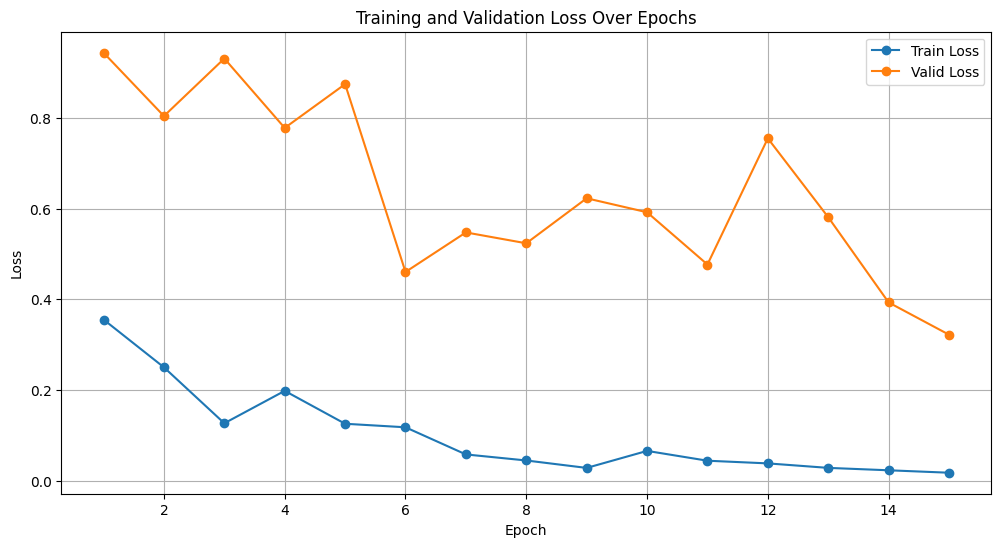

100%|██████████| 15/15 [02:34<00:00, 10.28s/it]

Epoch 15, Train Loss: 0.0177, Valid Loss: 0.3220, LR: 0.000125


In [30]:
train_model(model, train_dataset, valid_dataset, optimizer, criterion, num_epochs);

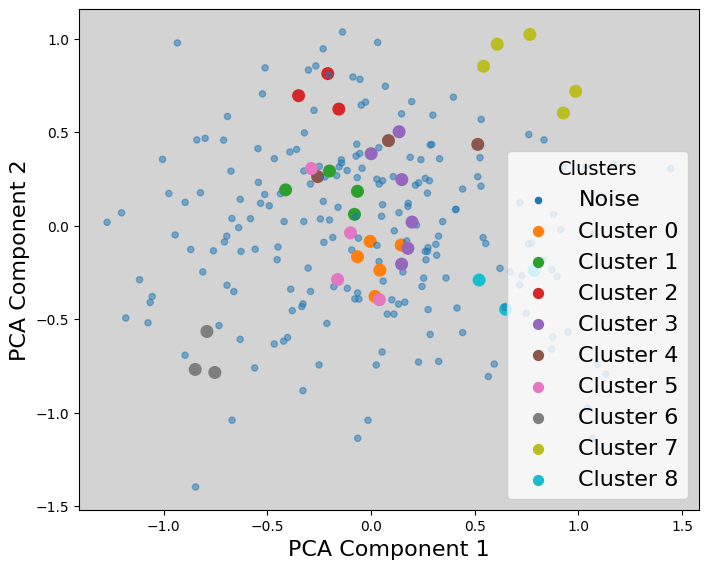

In [31]:
def extract_embeddings(model, dataset, device):
    """
    Извлекает эмбеддинги (выходы модели) для всех примеров в датасете.
    
    Аргументы:
      model (nn.Module): обученная модель.
      dataset (Dataset): датасет, из которого извлекаются эмбеддинги.
      device (torch.device): устройство, на котором работает модель.
    
    Возвращает:
      embeddings (numpy.ndarray): матрица эмбеддингов (num_samples x embedding_dim).
      indices (list): список индексов (или меток) для примеров.
    """
    model.eval()
    embeddings = []
    indices = []
    with torch.no_grad():
        for i, data in enumerate(dataset):
            adj, features, index = data
            adj = adj.to(device)
            features = features.to(device)
            output = model(adj, features)
            embeddings.append(output.cpu().numpy())
            indices.append(index)
    embeddings = np.vstack(embeddings)
    return embeddings, indices

embeddings, indices = extract_embeddings(model, train_dataset, "cpu")

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

optics = OPTICS(min_samples=3, xi=0.025, min_cluster_size=3, metric="euclidean")
clusters = optics.fit_predict(embeddings)

# Строим 2D-график с кластерами
plt.figure(figsize=(8, 6.5))
scatter = plt.scatter(
  embeddings_2d[:, 0], 
  embeddings_2d[:, 1], 
  c=clusters, 
  cmap='tab10',  
  s=np.where(clusters == -1, 20, 70),  
  alpha=np.where(clusters == -1, 0.5, 1)
)
plt.xlabel("PCA Component 1", fontsize=16)
plt.ylabel("PCA Component 2", fontsize=16)

# Создаем легенду для кластеров
unique_clusters = np.unique(clusters)
for cluster in unique_clusters:
  if cluster == -1:
    label = "Noise"
  else:
    label = f"Cluster {cluster}"
  plt.scatter([], [], color=scatter.cmap(scatter.norm(cluster)), label=label, s=50 if cluster != -1 else 20)

plt.legend(title="Clusters", fontsize=16, title_fontsize=14)
plt.gca().set_facecolor('lightgrey')
plt.show()

In [32]:
embeddings[0]

array([ 0.52670133, -0.36068106, -0.36084387,  1.0260293 , -0.8582118 ,
       -0.20075187, -2.027878  ,  0.74782604,  0.25266677, -0.38935554,
       -0.5135623 , -1.0122999 ,  1.1030436 , -2.5137663 , -1.2484426 ,
        0.00929363], dtype=float32)

In [33]:
def compute_correlation(models_dict, dataset, model, device="cpu"):
    model.to(device)  
    model.eval()

    N = len(dataset)

    embeddings = []
    with torch.no_grad():  
        for (adj, features, index) in dataset:
            adj = adj.to(device)
            features = features.to(device)

            embedding = model(adj, features).cpu().numpy() 
            embeddings.append(embedding)
    embeddings = np.array(embeddings)

    distance_matrix = cdist(embeddings, embeddings, metric="euclidean")
    
    architectures = [models_dict[index] for index in dataset.indices]
    similarity_matrix = np.zeros((N, N))
    for i in tqdm(range(N)):
        for j in range(i + 1, N):
            similarity_matrix[i, j] = get_diversity(architectures[i], architectures[j])
            similarity_matrix[j, i] = similarity_matrix[i, j]

    triu_indices = np.triu_indices(N, k=1)
    
    similarity_values = similarity_matrix[triu_indices]
    embedding_distances = distance_matrix[triu_indices]

    correlation, _ = pearsonr(embedding_distances, similarity_values)
    return correlation

Рассчитаю корреляции

In [34]:
pearson_correlation = compute_correlation(models_dict, valid_dataset, model)

print(f"Корреляция Пирсона: {pearson_correlation:.3f}")

100%|██████████| 60/60 [00:02<00:00, 25.44it/s]


Корреляция Пирсона: -0.290


In [35]:
min_samples = 25  

for i in range(len(set(clusters)) - 1):
    cluster_indexes = np.where(clusters == i)[0]
    print(cluster_indexes)
    
    positive_diversity = []
    negative_diversity = []
    
    for index in cluster_indexes:
        if index == cluster_indexes[0]:
            continue
        for _ in range(min_samples):
            positive, negative = get_positive_and_negative(discrete_diversity_matrix, cluster_indexes[0])
            if positive is None or negative is None:
                print(positive, negative)
                continue
            
            positive_diversity.append(get_diversity(models_dict[index], models_dict[positive]))
            negative_diversity.append(get_diversity(models_dict[index], models_dict[negative]))


    mean_positive_diversity = np.mean(positive_diversity) 
    mean_negative_diversity = np.mean(negative_diversity) 

    print(f"Cluster {i}:")
    print(f"  Mean Positive Diversity: {mean_positive_diversity:.4f}" if mean_positive_diversity is not None else "  No positive diversity data available.")
    print(f"  Mean Negative Diversity: {mean_negative_diversity:.4f}" if mean_negative_diversity is not None else "  No negative diversity data available.")


[ 45 108 124 175 201]
Cluster 0:
  Mean Positive Diversity: 0.7964
  Mean Negative Diversity: 0.7537
[ 25 135 147 217]
Cluster 1:
  Mean Positive Diversity: 0.8252
  Mean Negative Diversity: 0.7666
[ 22  86 174]
Cluster 2:
  Mean Positive Diversity: 0.7997
  Mean Negative Diversity: 0.7820
[ 89 141 194 198 206 216]
Cluster 3:
  Mean Positive Diversity: 0.8122
  Mean Negative Diversity: 0.7692
[ 48  54 103]
Cluster 4:
  Mean Positive Diversity: 0.8193
  Mean Negative Diversity: 0.7607
[ 57 144 187 229]
Cluster 5:
  Mean Positive Diversity: 0.8066
  Mean Negative Diversity: 0.7548
[ 37  67 168]
Cluster 6:
  Mean Positive Diversity: 0.8132
  Mean Negative Diversity: 0.7674
[ 50  52 170 183 191]
Cluster 7:
  Mean Positive Diversity: 0.7965
  Mean Negative Diversity: 0.7525
[ 72 111 185]
Cluster 8:
  Mean Positive Diversity: 0.8028
  Mean Negative Diversity: 0.7576


In [36]:
cluster_1_indexes = np.where(clusters == 0)[0]
cluster_2_indexes = np.where(clusters == 1)[0]

similarities_within_cluster_1 = [
    get_diversity(models_dict[i], models_dict[j])
    for i in cluster_1_indexes
    for j in cluster_1_indexes
    if i != j
]
mean_similarity_within_cluster_1 = np.mean(similarities_within_cluster_1)

similarities_between_clusters = [
    get_diversity(models_dict[i], models_dict[j])
    for i in cluster_1_indexes
    for j in cluster_2_indexes
]
mean_similarity_between_clusters = np.mean(similarities_between_clusters)

print(f"Средняя похожесть внутри первого кластера: {mean_similarity_within_cluster_1:.4f}")
print(f"Средняя похожесть между первым и вторым кластерами: {mean_similarity_between_clusters:.4f}")

Средняя похожесть внутри первого кластера: 0.7808
Средняя похожесть между первым и вторым кластерами: 0.7930


In [37]:
with open("logs.txt", "w", encoding="utf-8") as log:
    for index in cluster_1_indexes:
        tmp_graph = Graph(models_dict[index], index=index)
        for key, value in models_dict[index]["architecture"].items():
            log.write(f"{key}: {value}\n")
        log.write("\n")  # Добавляем пустую строку между архитектурами